
Reading --> conn.parq , SampleData: False 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22694356 entries, 0 to 22694355
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   ts         datetime64[ns]
 1   id_orig_h  object        
 2   id_resp_p  int64         
 3   duration   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 692.6+ MB
None

 Not http ports: 
                              id_orig_h  id_resp_p  duration
ts                                                          
2012-03-16 06:30:00.000  192.168.202.79        443      0.00
2012-03-16 06:30:00.000  192.168.202.79        443      0.02
2012-03-16 06:30:00.000  192.168.202.79        445     55.20
2012-03-16 06:30:00.020  192.168.202.79        443      0.01
2012-03-16 06:30:00.030  192.168.202.79        443      0.01
...                                 ...        ...       ...
2012-03-17 14:59:52.510  192.168.202.79      49998      0.00

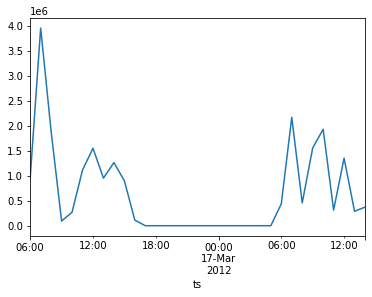


 Long duration connections: 
                                  id_orig_h  id_resp_p      duration
ts                                                                  
2012-03-17 09:15:39.240000   192.168.202.91        443  11249.610000
2012-03-17 09:15:39.480000   192.168.202.91        443  11249.590000
2012-03-17 09:16:40.310000   192.168.202.91        443  11174.590000
2012-03-17 09:16:17.390000   192.168.202.91        443  11174.570000
2012-03-17 09:16:35.970000   192.168.202.91        443  11174.570000
...                                     ...        ...           ...
2012-03-16 15:47:03.859999   192.168.202.87         53      5.000001
2012-03-17 08:59:24.499999  192.168.202.140      49153      5.000001
2012-03-17 09:17:41.899999  192.168.202.140      49155      5.000001
2012-03-16 14:09:36.499999   192.168.202.87         53      5.000001
2012-03-17 08:31:33.979999   192.168.202.94      49157      5.000001

[86906 rows x 3 columns]


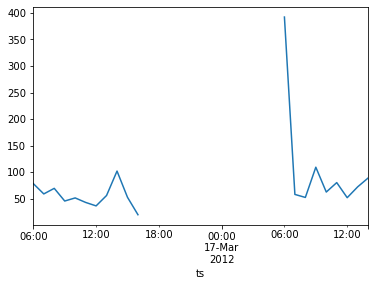


Tiempo del proceso ---> 29.13s


In [1]:
from pandas import DataFrame, read_parquet, read_csv
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from pprint import pprint
from time import time
from os import listdir
import sys

def get_random_sample_data(data: DataFrame, test_ratio: float):
    ''' permutation: Randomly permute a sequence or return a permuted range (ndarray).
                    If x is a multi-dimensional array, it is only shuffled along its first index.'''
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    # return the “x-first” values
    test_indices = shuffled_indices[:test_set_size]
    return data.iloc[test_indices]


def log_to_parquet(in_file: str, out_file: str, file_cols: list, parquet_engine: str):
    # LOAD DATA FROM A LOG FILE AND SAVE IT ON A PARQUET FILE TO IMPROVE PERFORMANCE AT READING THE DATA
    df = read_csv(in_file, sep="\t", header=None,
                  names=file_cols, low_memory=False)
    df.to_parquet(out_file, index=False, engine=parquet_engine)
    del df


def get_files_inFolder(folder: str, fileType: str):
    return list(filter(lambda fileName: 
                            fileName[-len(fileType):] == fileType,
                        listdir(folder)))
#---------------------------------------------------------------------------------------------
def conn_analysis(log_file: str, sample_data: bool):
    list_log_files = get_files_inFolder("./","log")
    list_parq_files = get_files_inFolder("./","parq")
    complete_name_f = log_file.split('.log')[0]+'.parq'
    sample_name_f = log_file.split('.log')[0]+'_sample.parq'
    P_ENGINE = "pyarrow"
    SAMPLE_SIZE = 0.10
    df = None
    if not complete_name_f in list_parq_files:
        if not log_file in list_log_files:
            print("ERROR fileNotFound: "+log_file)
            return 
        try:
            log_col_names = ["ts", "uid", "id_orig_h", "id_orig_p", "id_resp_h", "id_resp_p", "proto", "service", "duration", "orig_bytes", "resp_bytes",
                            "conn_state", "local_orig", "missed_bytes", "history", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents"]
            log_to_parquet(in_file=log_file, out_file=complete_name_f,
                            file_cols=log_col_names, parquet_engine=P_ENGINE)
        except Exception as e:
            print(e)
            return
    if sample_data and (not sample_name_f in list_parq_files):
        complete_df = read_parquet(complete_name_f, engine=P_ENGINE)
        sample_df = get_random_sample_data(complete_df, SAMPLE_SIZE)
        del complete_df
        sample_df.to_parquet(sample_name_f, index=False, engine=P_ENGINE)
        del sample_df

    important_cols = ["ts","id_orig_h", "id_resp_p", "duration"]
    to_read_file = sample_name_f if sample_data else complete_name_f
    print("\nReading -->",to_read_file,", SampleData:",sample_data,"\n")
    df = read_parquet(to_read_file, columns=important_cols)

    df = df[important_cols]
    df["ts"] = list(map(
        lambda date: 
            dt.fromtimestamp(float(date)),
        df["ts"].tolist()))
    df["duration"] = list(map(
        lambda dur: 
            float(dur) if not '-' in dur else 0.0,
        df["duration"].tolist()))
    print(df.info())
#---------------------------------------------------------------------------------------------
    df_not_web_port = df[(df["id_resp_p"] != 80) &
                         (df["id_resp_p"] != 8080)]
    df_not_web_port.set_index("ts",inplace=True)
    df_not_web_port = df_not_web_port.sort_index()
    print('\n', "Not http ports: ")
    pprint(df_not_web_port)
#---------------------------------------------------------------------------------------------
    df_gp_not_web_port = df_not_web_port.groupby(
        important_cols[1:3]).size().to_frame().reset_index()
    df_gp_not_web_port.rename(columns={0: "count"}, inplace=True)
    df_gp_not_web_port.sort_values(by="count", ascending=False, inplace=True)
    
    print('\n', "Not http ports count: ")
    pprint(df_gp_not_web_port)
    df_not_web_port['id_orig_h'].resample('H').count().plot()
    plt.show()
#---------------------------------------------------------------------------------------------
    df_long_conn = df[df["duration"] > 5]
    df_long_conn.set_index("ts",inplace=True)
    df_long_conn = df_long_conn.sort_index()
    df_long_conn['duration'].resample('H').mean().plot()
    df_long_conn.sort_values(by="duration", ascending=False, inplace=True)
    print('\n', "Long duration connections: ")
    pprint(df_long_conn)
    plt.show()

def main():
    intiTime = time()

    conn_analysis(log_file="conn.log", sample_data=False)
    # conn_analysis(log_file="conn.log", sample_data=True)

    elapsedTime = round(time()-intiTime, 2)
    elapsedTime = str(elapsedTime/60) + \
        "m" if elapsedTime >= 60 else str(elapsedTime)+"s"
    print("\nTiempo del proceso --->", elapsedTime)


main()
